In [326]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image


In [327]:
# Loading data
sentiment_path = Path(r"C:\Users\lucas\Desktop\Fintech Bootcamp\Project#2\Resources\BTC_sentiment.csv")
sentiment_df = pd.read_csv(sentiment_path)

sentiment_df_rename = sentiment_df.rename(columns={"ticks": "timestamp"})

#set index and date format
sentiment_df_index = sentiment_df_rename.set_index(pd.to_datetime(sentiment_df_rename['timestamp'], format = "%Y-%m-%d %H:%M:%S")).sort_index()

sentiment_df_index = sentiment_df_index[["Average of positive", "Average of negative", "Average of neutral"]]
#sentiment_df_index = sentiment_df_index[["Sentiment_Skew"]]
sentiment_df_index.head()

,Average of positive,Average of negative,Average of neutral
timestamp,,,
2021-06-27 05:00:00,0.0,0.139,0.861
2021-06-27 06:00:00,0.0,0.139,0.861
2021-06-27 07:00:00,0.0,0.139,0.861
2021-06-27 08:00:00,0.0,0.139,0.861
2021-06-27 09:00:00,0.0,0.139,0.861


In [328]:
options_path = Path(r"C:\Users\lucas\Desktop\Fintech Bootcamp\Project#2\Resources\BTC_Options.csv")
options_df = pd.read_csv(options_path)

#Add in type of instrument
options_df['Type'] = options_df['Instrument'].str[-1:]

#set index and date format
options_df_index = options_df.set_index(pd.to_datetime(options_df['timestamp'], format = "%Y-%m-%d %H:%M:%S")).sort_index()
options_df_index = options_df_index[["volume", "Type"]]
options_df_index.head()

,volume,Type
timestamp,,
2021-06-27 01:00:00,0.1,P
2021-06-27 02:00:00,0.1,C
2021-06-27 04:00:00,1.0,C
2021-06-27 05:00:00,0.0,P
2021-06-27 05:00:00,0.0,C


In [329]:
#group by date and type
options_trades_grouped = options_df_index.groupby(['timestamp', 'Type']).sum()
options_trades_grouped_df = options_trades_grouped.reset_index()
options_trades_grouped_df_index = options_trades_grouped_df.set_index(pd.to_datetime(options_trades_grouped_df['timestamp'], format = "%Y-%m-%d %H:%M:%S")).sort_index()
options_trades_grouped_df_index.head()

,timestamp,Type,volume
timestamp,,,
2021-06-27 01:00:00,2021-06-27 01:00:00,P,0.1
2021-06-27 02:00:00,2021-06-27 02:00:00,C,0.1
2021-06-27 04:00:00,2021-06-27 04:00:00,C,1.0
2021-06-27 05:00:00,2021-06-27 05:00:00,C,0.0
2021-06-27 05:00:00,2021-06-27 05:00:00,P,0.0


In [330]:
#segment by instrument type
puts_volume = options_trades_grouped_df_index.loc[options_trades_grouped_df_index['Type'] == 'P']
puts_volume = puts_volume[["Type", "volume"]]

calls_volume = options_trades_grouped_df_index.loc[options_trades_grouped_df_index['Type'] == 'C']
calls_volume = calls_volume[["Type", "volume"]]

calls_volume.tail()


,Type,volume
timestamp,,
2021-07-27 16:00:00,C,376.3
2021-07-27 17:00:00,C,53.2
2021-07-27 18:00:00,C,62.6
2021-07-27 19:00:00,C,4.2
2021-07-27 20:00:00,C,10.6


In [331]:
perp_path = Path(r"C:\Users\lucas\Desktop\Fintech Bootcamp\Project#2\Resources\BTC_Perp.csv")
perp_df = pd.read_csv(perp_path)
perp_df_rename = perp_df.rename(columns={"ticks": "timestamp" , "volume":"perp_volume"})

perp_df_index = perp_df_rename.set_index(pd.to_datetime(perp_df_rename['timestamp'], format = "%Y-%m-%d %H:%M:%S")).sort_index()
perp_df_index = perp_df_index[["perp_volume", "close", "price_variation"]]
perp_df_index.head()

,perp_volume,close,price_variation
timestamp,,,
2021-06-27 05:00:00,232.355717,32910.0,0
2021-06-27 06:00:00,432.951353,33100.0,1
2021-06-27 07:00:00,76.123128,33270.5,1
2021-06-27 08:00:00,352.966066,33019.0,0
2021-06-27 09:00:00,204.832090,32568.0,0


In [332]:
volatility_path = Path(r"C:\Users\lucas\Desktop\Fintech Bootcamp\Project#2\Resources\BTC_Volatility.csv")
volatility_df = pd.read_csv(volatility_path)

volatility_df_index = volatility_df.set_index(pd.to_datetime(volatility_df['date'], format = "%Y-%m-%d %H:%M:%S")).sort_index()
volatility_df_index = volatility_df_index[["volatility"]]

volatility_df_index.head()

,volatility
date,
2021-06-29 05:00:00,123.22
2021-06-29 06:00:00,145.56
2021-06-29 07:00:00,145.87
2021-06-29 08:00:00,121.68
2021-06-29 09:00:00,146.39


In [333]:
#merge dataframes
merged_df = puts_volume.merge(calls_volume, left_index=True, right_index = True)
merged_df_v2 = merged_df.merge(perp_df_index, left_index=True, right_index = True)
merged_df_v3 = merged_df_v2.merge(volatility_df_index, left_index=True, right_index = True)

merged_df_v3.head()

merged_df_v3_rename = merged_df_v3.rename(columns={"volume_x": "Put_Volume" , "volume_y":"Call_Volume", "close":"BTC_Price"})
merged_df_v3_rename = merged_df_v3_rename[["Put_Volume", "Call_Volume", "perp_volume", "BTC_Price", "volatility", "price_variation" ]]

merged_df_v4 = merged_df_v3_rename.merge(sentiment_df_index, left_index=True, right_index = True)

merged_df_v4.head()

,Put_Volume,Call_Volume,perp_volume,BTC_Price,volatility,price_variation,Average of positive,Average of negative,Average of neutral
2021-06-29 05:00:00,10.1,12.8,187.677513,34730.0,123.22,0,0.0468,0.0278,0.9254
2021-06-29 07:00:00,1.2,1.7,1668.190410,34870.0,145.87,0,0.0468,0.0278,0.9254
2021-06-29 08:00:00,6.3,2.1,563.459319,35080.0,121.68,1,0.0468,0.0278,0.9254
2021-06-29 09:00:00,16.0,2.9,227.123555,35224.5,146.39,0,0.0468,0.0278,0.9254
2021-06-29 12:00:00,0.0,0.0,240.456059,35817.5,147.19,1,0.0468,0.0278,0.9254


In [334]:
#RANDOM FOREST ANALYSIS
# Define features set
# price_variation is '1' if more than +1% and '0' if below that
X = merged_df_v4.copy()
X.drop("price_variation", axis=1, inplace=True)
X.head()


,Put_Volume,Call_Volume,perp_volume,BTC_Price,volatility,Average of positive,Average of negative,Average of neutral
2021-06-29 05:00:00,10.1,12.8,187.677513,34730.0,123.22,0.0468,0.0278,0.9254
2021-06-29 07:00:00,1.2,1.7,1668.190410,34870.0,145.87,0.0468,0.0278,0.9254
2021-06-29 08:00:00,6.3,2.1,563.459319,35080.0,121.68,0.0468,0.0278,0.9254
2021-06-29 09:00:00,16.0,2.9,227.123555,35224.5,146.39,0.0468,0.0278,0.9254
2021-06-29 12:00:00,0.0,0.0,240.456059,35817.5,147.19,0.0468,0.0278,0.9254


In [335]:
# Define target vector
y = merged_df_v4["price_variation"].ravel()
y[:5]

array([0, 0, 1, 0, 1], dtype=int64)

In [336]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [337]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [338]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [339]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [340]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [341]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [342]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [343]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [344]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,90,4
Actual 1,13,0


Accuracy Score : 0.8411214953271028
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        94
           1       0.00      0.00      0.00        13

    accuracy                           0.84       107
   macro avg       0.44      0.48      0.46       107
weighted avg       0.77      0.84      0.80       107



In [345]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

In [346]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2129471503281065, 'BTC_Price'),
 (0.19910297641170463, 'perp_volume'),
 (0.1987203918148142, 'volatility'),
 (0.10656552617338517, 'Call_Volume'),
 (0.10205317263716937, 'Put_Volume'),
 (0.06919765641125403, 'Average of neutral'),
 (0.06176185014496457, 'Average of positive'),
 (0.04965127607860142, 'Average of negative')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

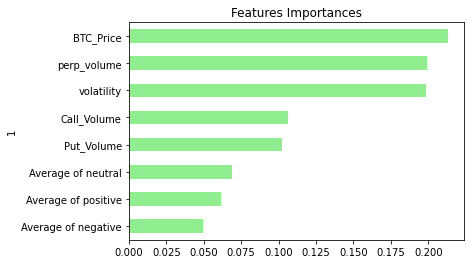

In [347]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [348]:
#Decision Trees
# Define features set
X = merged_df_v4.copy()
X.drop("price_variation", axis=1, inplace=True)
X.head()

,Put_Volume,Call_Volume,perp_volume,BTC_Price,volatility,Average of positive,Average of negative,Average of neutral
2021-06-29 05:00:00,10.1,12.8,187.677513,34730.0,123.22,0.0468,0.0278,0.9254
2021-06-29 07:00:00,1.2,1.7,1668.190410,34870.0,145.87,0.0468,0.0278,0.9254
2021-06-29 08:00:00,6.3,2.1,563.459319,35080.0,121.68,0.0468,0.0278,0.9254
2021-06-29 09:00:00,16.0,2.9,227.123555,35224.5,146.39,0.0468,0.0278,0.9254
2021-06-29 12:00:00,0.0,0.0,240.456059,35817.5,147.19,0.0468,0.0278,0.9254


In [349]:
# Define target vector
y = merged_df_v4["price_variation"].values.reshape(-1, 1)
y[:5]


array([[0],
       [0],
       [1],
       [0],
       [1]], dtype=int64)

In [350]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [351]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [352]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)


In [353]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [354]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [355]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [356]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [357]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [358]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,78,16
Actual 1,11,2


Accuracy Score : 0.7476635514018691
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        94
           1       0.11      0.15      0.13        13

    accuracy                           0.75       107
   macro avg       0.49      0.49      0.49       107
weighted avg       0.78      0.75      0.76       107



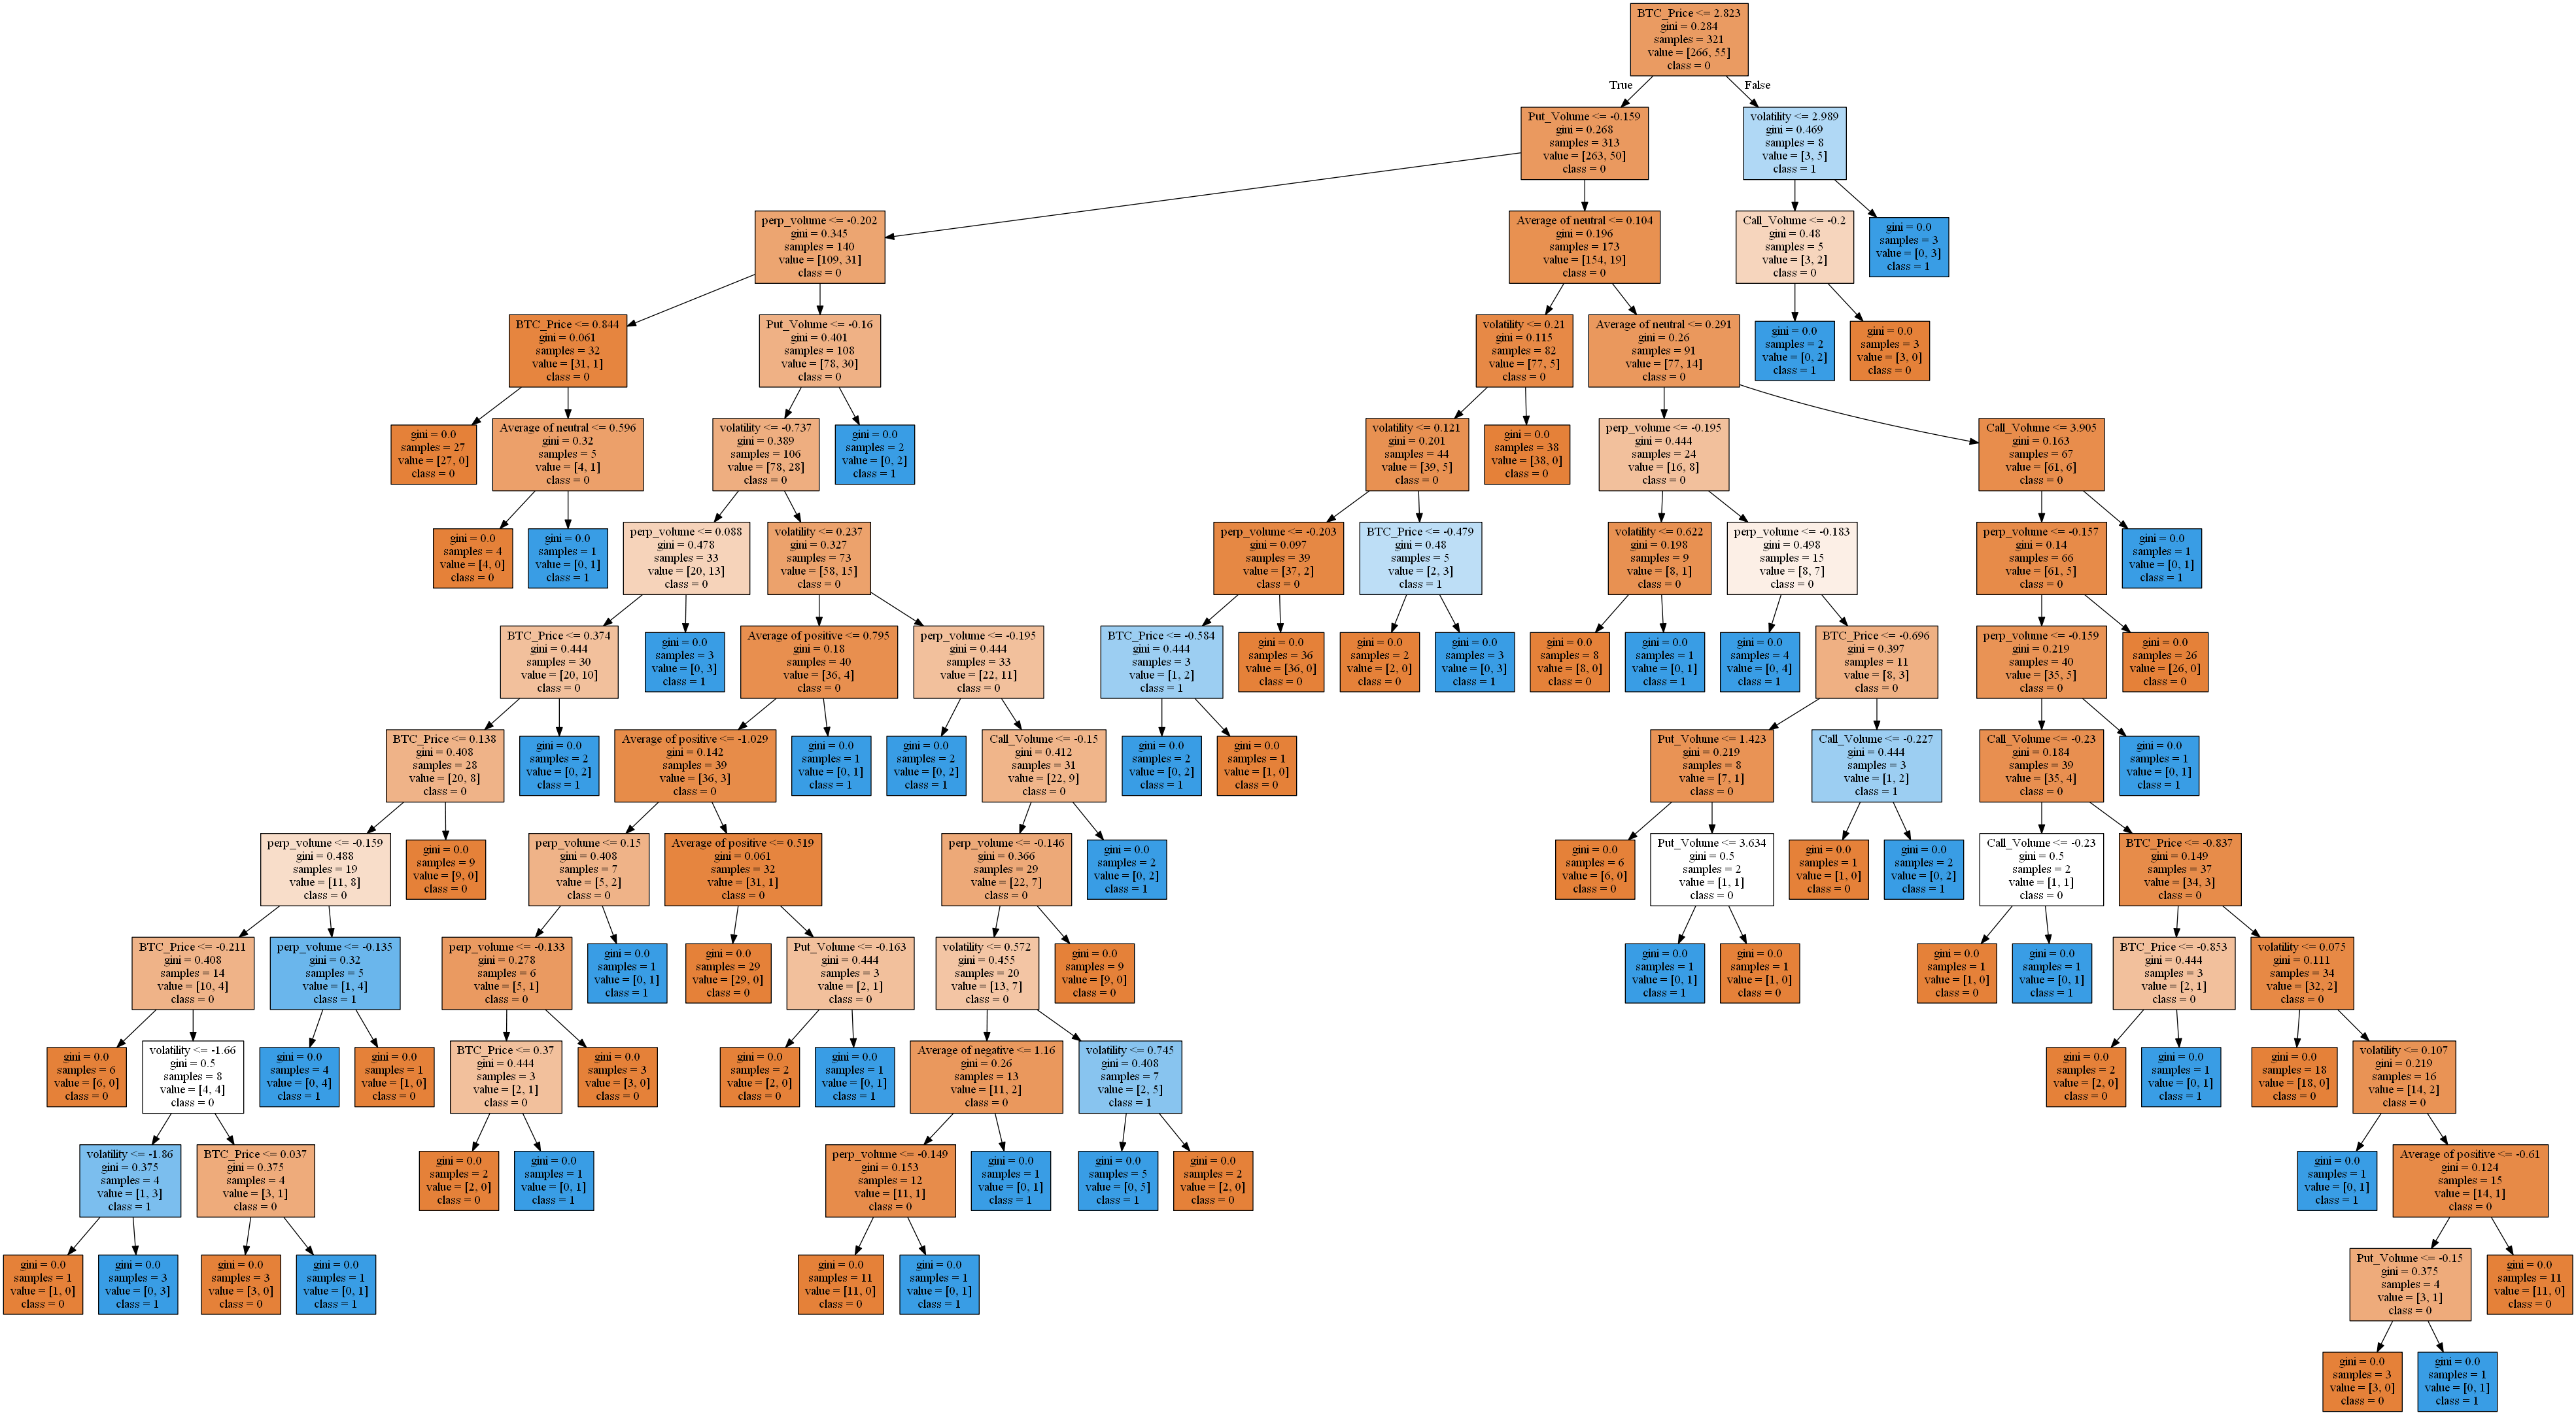

In [359]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [360]:
# GRADIENT BOOSTED TREE

In [361]:
# Define features set
X = merged_df_v4.copy()
X.drop("price_variation", axis=1, inplace=True)
X.head()

,Put_Volume,Call_Volume,perp_volume,BTC_Price,volatility,Average of positive,Average of negative,Average of neutral
2021-06-29 05:00:00,10.1,12.8,187.677513,34730.0,123.22,0.0468,0.0278,0.9254
2021-06-29 07:00:00,1.2,1.7,1668.190410,34870.0,145.87,0.0468,0.0278,0.9254
2021-06-29 08:00:00,6.3,2.1,563.459319,35080.0,121.68,0.0468,0.0278,0.9254
2021-06-29 09:00:00,16.0,2.9,227.123555,35224.5,146.39,0.0468,0.0278,0.9254
2021-06-29 12:00:00,0.0,0.0,240.456059,35817.5,147.19,0.0468,0.0278,0.9254


In [362]:
# Define target vector
y = merged_df_v4["price_variation"].values.reshape(-1, 1)
y[:5]

array([[0],
       [0],
       [1],
       [0],
       [1]], dtype=int64)

In [363]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [364]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.844
Accuracy score (validation): 0.869

Learning rate:  0.1
Accuracy score (training): 0.844
Accuracy score (validation): 0.869

Learning rate:  0.25
Accuracy score (training): 0.891
Accuracy score (validation): 0.841

Learning rate:  0.5
Accuracy score (training): 0.960
Accuracy score (validation): 0.832

Learning rate:  0.75
Accuracy score (training): 0.991
Accuracy score (validation): 0.804

Learning rate:  1
Accuracy score (training): 0.997
Accuracy score (validation): 0.766



In [365]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=1,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,0,0
9,0,0


In [366]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.7663551401869159


In [367]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,82,12
Actual 1,13,0


In [368]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        94
           1       0.00      0.00      0.00        13

    accuracy                           0.77       107
   macro avg       0.43      0.44      0.43       107
weighted avg       0.76      0.77      0.76       107



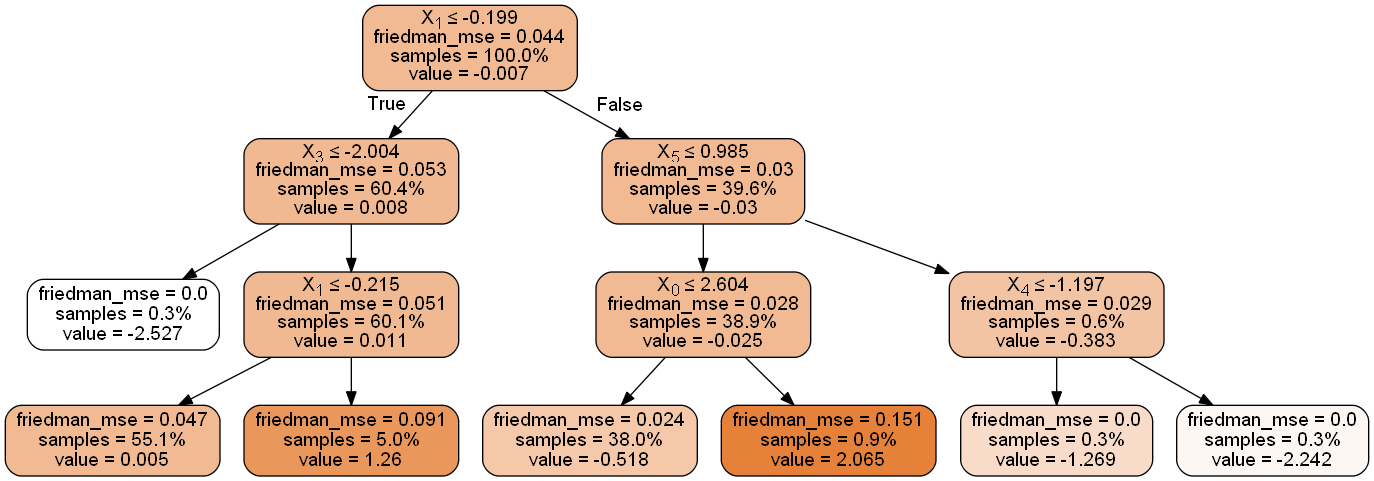

In [369]:
# Graph tree
dot_data = tree.export_graphviz(
    classifier.estimators_[9, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())